## Importing libraries

In [1]:
!pip install yfinance

In [2]:
!pip install pandas-datareader

In [3]:
!pip install tensorflow

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas_datareader import data as pdr
import yfinance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

## Fetching  the data

In [5]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("INFY", start="2022-01-01").reset_index()
df_full.to_csv('INFY.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,25.389999,25.540001,25.150000,25.260000,24.712013,4526700
1,2022-01-04,25.250000,25.370001,24.980000,25.110001,24.565268,8180900
2,2022-01-05,24.840000,24.920000,24.250000,24.299999,23.772839,8881400
3,2022-01-06,24.200001,24.490000,23.969999,24.110001,23.586962,11523300
4,2022-01-07,24.219999,24.370001,23.969999,24.200001,23.675009,6596500


## Define the Q-Learning Agent


In [6]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

## Train the Agent

In [7]:
close = df.Close.values.tolist()
initial_money = 15000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

C:\Users\RICK\AppData\Local\Temp\ipykernel_18768\2714956697.py:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
C:\Users\RICK\AppData\Local\Temp\ipykernel_18768\2714956697.py:23: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 10, total rewards: -1.080000.3, cost: 0.007066, total money: 14998.920000
epoch: 20, total rewards: -0.980000.3, cost: 0.006261, total money: 14999.020000
epoch: 30, total rewards: 0.560001.3, cost: 0.002398, total money: 15000.560001
epoch: 40, total rewards: -0.689999.3, cost: 0.005263, total money: 14999.310001
epoch: 50, total rewards: -1.340000.3, cost: 0.004854, total money: 14998.660000
epoch: 60, total rewards: -1.019999.3, cost: 0.004530, total money: 14998.980001
epoch: 70, total rewards: -0.919998.3, cost: 0.003847, total money: 14999.080002
epoch: 80, total rewards: -0.809998.3, cost: 0.004001, total money: 14999.190002
epoch: 90, total rewards: -0.029999.3, cost: 0.003667, total money: 14999.970001
epoch: 100, total rewards: 0.050001.3, cost: 0.003983, total money: 15000.050001
epoch: 110, total rewards: 1.200001.3, cost: 0.002022, total money: 15001.200001
epoch: 120, total rewards: 1.890001.3, cost: 0.002011, total money: 15001.890001
epoch: 130, total rewards: 2.

## Test the Agent


In [8]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 25.260000, total balance 14974.740000
day 3: buy 1 unit at price 24.110001, total balance 14950.629999
day 4, sell 1 unit at price 24.200001, investment -4.196356 %, total balance 14974.830000,
day 9, sell 1 unit at price 26.200001, investment 8.668603 %, total balance 15001.030001,
day 71: buy 1 unit at price 20.459999, total balance 14980.570002
day 72, sell 1 unit at price 20.559999, investment 0.488760 %, total balance 15001.130001,
day 160: buy 1 unit at price 19.250000, total balance 14981.880001
day 161, sell 1 unit at price 19.250000, investment 0.000000 %, total balance 15001.130001,
day 169: buy 1 unit at price 17.980000, total balance 14983.150002
day 170, sell 1 unit at price 18.430000, investment 2.502785 %, total balance 15001.580002,
day 182: buy 1 unit at price 16.610001, total balance 14984.970001
day 185, sell 1 unit at price 17.110001, investment 3.010235 %, total balance 15002.080002,
day 187: buy 1 unit at price 16.969999, total balance 1

## Plot the total gains vs the invested figures.

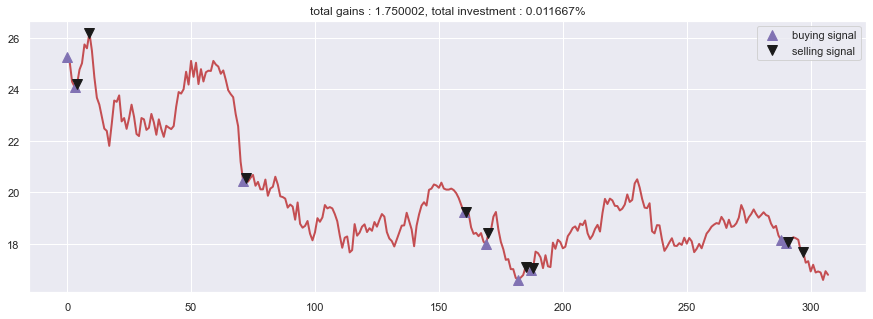

In [9]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains : %f, total investment : %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()